# **COVID-19 Cases Prediction (Regression)**

__Name:__ Ya-Wei Tsai


__Summary__:


* Feature Selection:

  filter features by their correlation to the target value & manually selected by mearning of the column.

* Train/Valid Ratio:
  
  ratio of the training & validation set is changed to 4:1, instead of 9:1.

* Normalization:

  the validation & testing set were normalized based on the mean and standard deviation of training set.

* Batch Size: changed to 64.

* L2 Reguralization: $\lambda = 5*10^{-5}$

* Optimizer:

  Adam with learning rate of 0.01 and weight decay of 0.005 is adopted.

* Learning Rate Scheduling: $lr_{epoch}=0.996^{epoch}*lr_{0}$

* DNN Architecture: 1 hidden layer with size of 16 units was used.

* Stacking Method:

  XGBoost & SVM were adopted to produce the final predictions. The hyperparameters for these regressors were tuning based on the same validation set in training of DNN. In the end, the prediction of DNN, XGBoost and SVM were weighted with ratio of 0.5, 0.2, 0.3 respectively.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [ ]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 31.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 10.2MB/s]


# **Import Some Packages**

In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import os
import csv
import pickle
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
myseed = 666
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Utilities**

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Feature Selection**

Select feature based on __1. the correlation to the target value__ and __2. human judgement__ (based on meaning of the column).

In [ ]:
df = pd.read_csv('covid.train.csv').iloc[:,1:]
print(df.columns[df.corr().iloc[:,-1] > 0.3])

features_index = [40, 41, 42, 43, 47, 51, 56, 57, 58, 59, 60, 61, 65, 69, 74, 75, 76, 77, 78, 79, 83, 87, 92]

Index(['cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli', 'worried_finances',
       'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1',
       'nohh_cmnty_cli.1', 'worried_finances.1', 'tested_positive.1', 'cli.2',
       'ili.2', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'worried_finances.2',
       'tested_positive.2'],
      dtype='object')


## **Dataset**

In [ ]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self, path, mode='train'):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        feats = [40, 41, 42, 43, 47, 51, 56, 57, 58, 59, 60, 61, 65, 69, 74, 75, 76, 77, 78, 79, 83, 87, 92]

        if mode == 'test':
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 5 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 5 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalization
        ## training scaler
        if mode == 'train':
            scaler = {
                'mean': self.data.mean(dim=0, keepdim=True),
                'std': self.data.std(dim=0, keepdim=True),
            }
            pickle.dump(scaler, open('scaler.pickle', 'wb'))

        ## normalize features
        scaler = pickle.load(open('scaler.pickle', 'rb'))
        self.data = (self.data - scaler['mean']) / scaler['std']
        self.dim = self.data.shape[1]

    def __getitem__(self, index):
        if self.mode in ['train', 'dev']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    # dataet
    dataset = COVID19Dataset(path, mode=mode)

    # dataloader
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    return dataloader

# **Deep Neural Network**


In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, l2 = 0):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        self.l2 = l2

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):

        # l2 regularization
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.sum(torch.square(param))

        return self.criterion(pred, target)+ self.l2*l2_loss

## **Train/Dev/Test**

In [ ]:
# Train
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
    
    # Learning rate scheduler
    lambda1 = lambda epoch: config['lambda'] ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in tr_set:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            mse_loss = model.cal_loss(pred, y)
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())
        
        # schedule learning rate
        scheduler.step()

        # Validation
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_mse))
            
            # save model
            torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)

        # Early Stopping
        if early_stop_cnt > config['early_stop']:
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

# Validation
def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            mse_loss = model.cal_loss(pred, y)
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
    return total_loss

# Test
def test(tt_set, model, device):
    model.eval()
    preds = []
    for x in tt_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

## **Hyper-parameters**

In [ ]:
device = get_device()
os.makedirs('models', exist_ok=True)

config = {
    'n_epochs': 3000,
    'batch_size': 64,
    'optimizer': 'Adam',
    'optim_hparas': {
        'lr': 0.01,
        'weight_decay': 0.005, 
    },
    'lambda': 0.996,
    'early_stop': 200,
    'save_path': 'models/model.pth'
}

## **Load data and model**

In [ ]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'])
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'])
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'])

## **Training Process**

In [ ]:
model = NeuralNet(tr_set.dataset.dim, l2=0.00005).to(device)  # Construct model and move to device,
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 114.4816)
Saving model (epoch =    2, loss = 54.6249)
Saving model (epoch =    3, loss = 21.0256)
Saving model (epoch =    4, loss = 11.5822)
Saving model (epoch =    5, loss = 7.1032)
Saving model (epoch =    6, loss = 4.7389)
Saving model (epoch =    7, loss = 3.1620)
Saving model (epoch =    8, loss = 2.3317)
Saving model (epoch =    9, loss = 1.7773)
Saving model (epoch =   10, loss = 1.4640)
Saving model (epoch =   12, loss = 1.2396)
Saving model (epoch =   13, loss = 1.1509)
Saving model (epoch =   14, loss = 1.0927)
Saving model (epoch =   17, loss = 1.0489)
Saving model (epoch =   18, loss = 1.0124)
Saving model (epoch =   22, loss = 0.9346)
Saving model (epoch =   29, loss = 0.9205)
Saving model (epoch =   30, loss = 0.8458)
Saving model (epoch =   42, loss = 0.8296)
Saving model (epoch =   57, loss = 0.8284)
Saving model (epoch =   72, loss = 0.8277)
Saving model (epoch =   82, loss = 0.8090)
Saving model (epoch =   88, loss = 0.8057)
Saving

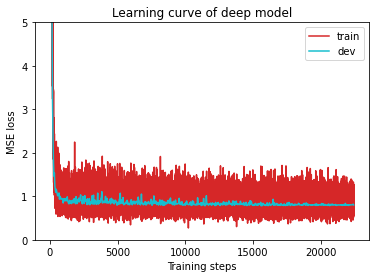

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

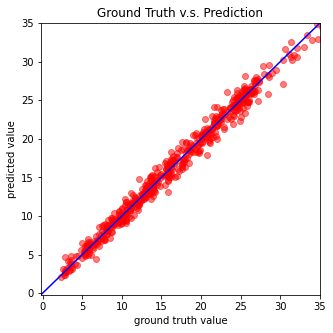

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**

## __Stacking__

Other regression models, e.g. SVM, XGboost, are combined with DNN to predict the testing set.

In [ ]:
import xgboost as xg
from sklearn.svm import SVR

# training & testing set
df_train = pd.read_csv('covid.train.csv').iloc[:,1:]
df_test = pd.read_csv('covid.test.csv').iloc[:,1:]
  
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',gamma=0.5,reg_alpha=1.5,n_estimators = 130, max_depth=4)
svm = SVR(kernel="linear", C=1.3)

# Fitting the model 
xgb_r.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1]) 
svm.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## __Prediction__

For the stacking method, ratios of 0.5, 0.2, 0.3 were chosen for weighting the prediction of DNN, XGBoost and SVM resepectively.

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

# base regressors
preds_DNN = test(tt_set, model, device)
pred_xgb = xgb_r.predict(df_test) 
pred_svm = svm.predict(df_test) 

# ensemble prediction from DNN, XGBoost, SVM
preds_ensemble = (0.5*preds_DNN + 0.2*pred_xgb + 0.3*pred_svm)

# save prediction file to pred.csv
save_pred(preds_ensemble, 'pred_5_4.csv')

Saving results to pred_5_4.csv
